# Problem Statement

Environment:   Assume you have a square region in the plane which is discretized.   Also assume you have some obstacles in the planar region.  

1. Use a modification of the Brushfire algorithm to find the GVD.
2. Modify your A* algorithm (or something equivalent) to find a path between points on the GVD.
3. Modify the steepest descent code from a potential function algorithm to route from any point in free space to the GVD and the reverse.

# Creating an environment with random obstacles

In the following section, we use code from previous homeworks to create and discretize an environment with multiple polygon shaped obstacles. I added one modification that tries to merge multiple intersecting polygons together into a single polygon while I'm discretizing the region. This works for a lot of cases, but will fail to join polygons if they are in a weird sequence. I subsequently realized that joining the obstacles like this can actually cause failures because it is possible to generate concave obstacles and this can create inescapable brushfire regions. I have included a test obstacle below that illustrates this problem.

We initialize two maps. One of them will keep track of the distances from the obstacles. The other will keep track of which obstacle is closest to each point in the region. Later we will use them both to create our roadmap and traverse it.

In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
plt.rcParams['figure.figsize'] = [5,5]
import heapq
import cv2
import time

def make_poly(x, y, r, n):
    """Make a convex polygon centered at (x,y) """
    ts = np.sort(np.random.uniform(0, 2*np.pi, n))
    rs = np.random.uniform(r*0.9, r*1.1, n)

    pts = np.array([rs*np.cos(ts) + x, rs*np.sin(ts) + y]).T

    poly = plt.Polygon(pts)
    return poly

def generate_random_obstacles(n, obs_type, start_pt, goal_pt):
    sigma = 2
    obstacles = []
    for i in range(n):
        x = np.random.uniform(-5,5)
        y = np.random.uniform(-5,5)
        r = np.random.uniform(0.5, 1)
        if obs_type == "circles":
            patch = plt.Circle([x, y], r)
        elif obs_type == "polygons":
            patch = make_poly(x, y, r, 6)
        else:
            raise RuntimeError("Valid obstacle types are 'circles' or 'polygons'")
        while patch.contains_point(start_pt) or patch.contains_point(goal_pt):
            x = np.random.uniform(-5,5)
            y = np.random.uniform(-5,5)
            r = np.random.uniform(0.5, 1)
            if obs_type == "circles":
                patch = plt.Circle([x, y], r)
            elif obs_type == "polygons":
                patch = make_poly(x, y, r, 6)
        obstacles.append(patch)
    return obstacles

In [2]:
def convert_obstacles_to_image(obstacles, img_shape, start_pt, goal_pt):
    img = -1*np.ones(img_shape)
    obs_index_img = -1*np.ones(img_shape,dtype="int")
    xmin = -5
    xmax = 5
    xs = np.linspace(xmin, xmax, img_shape[1])
    ymin = xmin*img_shape[0]/img_shape[1]
    ymax = xmax*img_shape[0]/img_shape[1]
    ys = np.linspace(ymin, ymax, img_shape[0])
    
    max_obs_index = 0
    
    all_obs_pts = [[]]

    for obs_index,obs in enumerate(obstacles):
        obs_index = max_obs_index
        extent = obs.get_window_extent()
        imin = int((min(max(xmin, extent.x0), xmax)-xmin)
                   * img_shape[1]/(xmax-xmin))
        imax = int((min(max(xmin, extent.x1), xmax)-xmin)
                   * img_shape[1]/(xmax-xmin))
        jmin = int((min(max(ymin, extent.y0), ymax)-ymin)
                   * img_shape[0]/(ymax-ymin))
        jmax = int((min(max(ymin, extent.y1), ymax)-ymin)
                   * img_shape[0]/(ymax-ymin))
        obs_pts = []
        for i in range(imin, imax):
            for j in range(jmin, jmax):
                if obs.contains_point([xs[i], ys[j]]):
                    img[j, i] = 0
                    obs_pts.append([i,j])
#                     if obs_index_img[j,i] != -1:
    
#                         obs_index = obs_index_img[j,i]
        if obs_index == max_obs_index:
            max_obs_index += 1
            all_obs_pts.append([])
        
        for i,j in obs_pts:
            obs_index_img[j,i] = obs_index
        all_obs_pts[obs_index] += obs_pts
                    
    A = np.array([[img_shape[1]/(xmax-xmin), 0],
                  [0, img_shape[0]/(ymax-ymin)]])
    xscale = img_shape[1]/(xmax-xmin)
    yscale = img_shape[0]/(ymax-ymin)
    new_start = np.array(
        [(start_pt[0]-xmin)*xscale, (start_pt[1]-ymin)*yscale], dtype='int')
    img[new_start[1],new_start[0]] = -1
    new_goal = np.array(
        [(goal_pt[0]-xmin)*xscale, (goal_pt[1]-ymin)*yscale], dtype='int')
    img[new_goal[1], new_goal[0]] = -1
    return img, all_obs_pts, new_start, new_goal

def create_map(num_obstacles, obstacle_type, map_size):
    global obstacles
    start_pt = np.array([-3, 3])
    goal_pt = np.array([3, -3])
    start_pt = np.random.uniform([-5, -5], [0, 5], 2)
    goal_pt = np.random.uniform([0, -5], [5, 5], 2)
    obstacles = generate_random_obstacles(
        num_obstacles, obstacle_type, start_pt, goal_pt)
    img, all_obs_pts, img_start_pt, img_goal_pt = convert_obstacles_to_image(
        obstacles, (map_size, map_size), start_pt, goal_pt)
    return img, all_obs_pts, img_start_pt, img_goal_pt

Text(0.5, 1.0, 'Random discretized polygonal obstacles \ncolored by obstacle index')

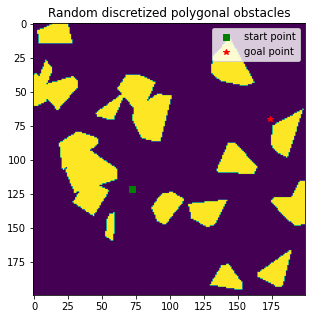

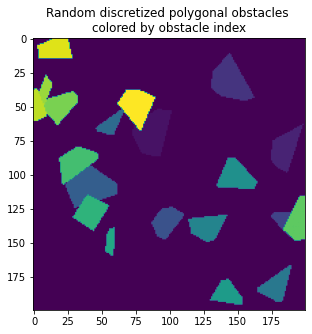

In [11]:
img, all_obs_pts, img_start_pt, img_goal_pt = create_map(20, "polygons", 200)
plt.figure()
plt.imshow(img)
plt.plot(img_start_pt[0], img_start_pt[1], 'gs', label='start point')
plt.plot(img_goal_pt[0], img_goal_pt[1], 'r*', label='goal point')
plt.legend()
plt.title("Random discretized polygonal obstacles")

obs_img = -1*np.ones_like(img)
for i, obs_pts in enumerate(all_obs_pts):
    for pt in obs_pts:
        obs_img[pt[1],pt[0]] = i
plt.figure()
plt.imshow(obs_img)
plt.title("Random discretized polygonal obstacles \ncolored by obstacle index")

# Implement brushfire algorithm

Let the set of pixels that is contained within obstacles be considered level 0. Let the ring of pixels directly adjacent to an obstacle be considered level 1. Each subsequent ring extending from the obstacle will be a new level. Viewed another way, consider the brushfire map to be a topological map. Each level would be the set of pixels that are at constant elevation or at a constant distance from an obstacle.

The goal of the brushfire algorithm is to identify which pixels belong to which level. This is done by first identifying all of the level 0 pixels and putting them in a list. We then iterate through the list, appending adjacent nodes that have not yet been handled to the list. To generate the Generalized Voronoi Diagram (GVD), we also have to keep track of which obstacle is closest to each point that is discovered.

I modified the brushfire algorithm to keep track of which obstacle is nearest to a point as follows. I defined a list of lists of lists for which the first index identified the level and the second index identified the nearest obstacle. Thus, `levels[3][4]` would return a list of all the pixel positions that have a level of 3 and came from obstacle 4. The algorithm remains very similar that of the previous paragraph. Instead of putting each new point into one large list, we place it into the appropriate sublist. We first iterate through each obstacle at level 0, filling each obstacle's level 1 list, then we move on to level 1, filling level 2 and so on until there are no adjacent unhandled pixels.

The resulting maps can be nicely visualized using `imshow()`. I also chose to leave the map values within the obstacles at -1 so that the obstacles can still be seen within their respective regions on the map.

In [4]:
pairs = [[-1, -1], [0, -1], [1, -1], [-1, 0], [1, 0], [-1, 1], [0, 1], [1, 1]]

test_img_2 = np.array(
[
    [-1,-1,-1,-1],
    [-1,0,0,-1],
    [-1,0,0,-1],
    [-1,-1,-1,-1]
])

def find_empty_neighbors(img, pt):
    empty_neighbors = []
    for pair in pairs:
        a = pt[0] + pair[0]
        b = pt[1] + pair[1]
        if a >= 0 and a < img.shape[1] and b >= 0 and b < img.shape[0] and img[b,a] == -1:
            empty_neighbors.append([a,b])
    return empty_neighbors

def test_empty_neighbors():
    empty_neighbors = find_empty_neighbors(test_img_2, [1,1])
#     print(empty_neighbors)
    
    empty_neighbors = find_empty_neighbors(test_img_2, [0,0])
#     print(empty_neighbors)

test_empty_neighbors()

def color_empty_neighbors(img, empty_neighbors, level):
    for neighbor in empty_neighbors:
        img[neighbor[1],neighbor[0]] = level
    return img

def test_color_neighbors():
    empty_neighbors = find_empty_neighbors(test_img_2, [1,1])
    new_img = color_empty_neighbors(test_img_2, empty_neighbors, 1)
#     plt.figure()
#     plt.imshow(new_img)
#     plt.colorbar()

test_color_neighbors()
def brushfire(img, obs_img, all_obs_pts):
    img = img.copy()
    obs_img = -1*np.ones_like(img)
    finished = False
    level_idx = 0
    levels = []
    levels.append(all_obs_pts)
    while not finished:
        finished = True
        level = levels[level_idx]
        next_level = []
        for obs_idx, curr_ring in enumerate(level):
            next_ring = []
            for pt in curr_ring:
                empty_neighbors = find_empty_neighbors(img, pt)
                if len(empty_neighbors) > 0:
                    finished = False
                img = color_empty_neighbors(img, empty_neighbors, level_idx+1)
                obs_img = color_empty_neighbors(obs_img, empty_neighbors, obs_idx)
                next_ring = next_ring + empty_neighbors
            next_level.append(next_ring)
        levels.append(next_level)
        level_idx += 1
    return img, obs_img

# Show the importance of convex obstacles

The following section generates three convex obstacles that, when joined together, create an inescapable concave region. This case caused problems for my previous algorithm that tried to join connected obstacles together into a single obstacle. In this case, if the obstacles are all connected together, then you can't get from the interior of the triangular region to the edges of the GVD because the edges are all outside the obstacle and the gradients within the obstacle trap you inside. For this reason, it's best to avoid joining obstacles together into a single larger obstacle. If the obstacles are convex, as shown below, the GVD will generate an edge that leads from the interior to the exterior, fully connecting the space.

Text(0.5, 1.0, 'The Generalized Voronoi Diagram for convex \nobstacles creates a path out of the trap')

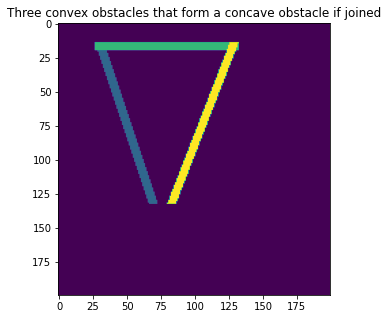

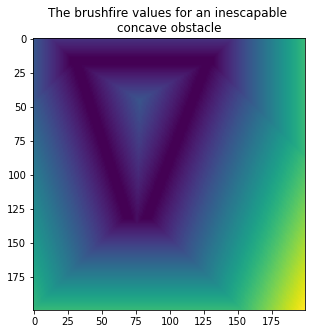

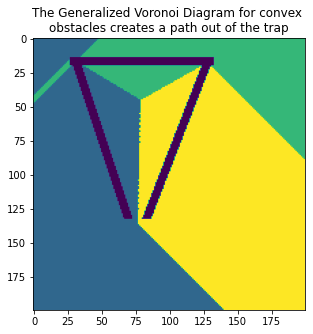

In [12]:
obs1_x = [50.,40,100,110]
obs1_y = [20,20,200,200]
obs1_pts = np.array([obs1_x,obs1_y]).T
obs1_pts *= 10/300
obs1_pts -= 5
patch1 = plt.Polygon(obs1_pts)

obs2_x = [40.,40,200,200]
obs2_y = [30,20,20,30]
obs2_pts = np.array([obs2_x,obs2_y]).T
obs2_pts *= 10/300
obs2_pts -= 5
patch2 = plt.Polygon(obs2_pts)

obs3_x = [120.,130, 200,190]
obs3_y = [200,200,20,20]
obs3_pts = np.array([obs3_x,obs3_y]).T
obs3_pts *= 10/300
obs3_pts -= 5
patch3 = plt.Polygon(obs3_pts)


test_obstacles = [patch1, patch2, patch3]
test_img, test_all_obs_pts, test_new_start, test_new_goal = convert_obstacles_to_image(test_obstacles, (200,200), (-2,-3), (3,0))

test_obs_img = -1*np.ones_like(img)
for i, test_obs_pts in enumerate(test_all_obs_pts):
    for pt in test_obs_pts:
        test_obs_img[pt[1],pt[0]] = i

plt.figure()
plt.imshow(test_obs_img)
plt.title("Three convex obstacles that form a concave obstacle if joined")

test_img_done, test_obs_img_done = brushfire(test_img, test_obs_img, test_all_obs_pts)

plt.figure()
plt.imshow(test_img_done)
plt.title("The brushfire values for an inescapable \nconcave obstacle")

plt.figure()
plt.imshow(test_obs_img_done)
plt.title("The Generalized Voronoi Diagram for convex \nobstacles creates a path out of the trap")

# Do brushfire on a map of random obstacles

Now that we have all the tools, we can separate the space into the Voronoi regions for a map of random obstacles and show the brushfire values as well.

Text(0.5, 1.0, 'The Generalized Voronoi Diagram indicating \nwhich regions are closest to which obstacles')

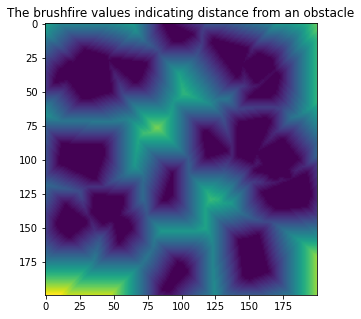

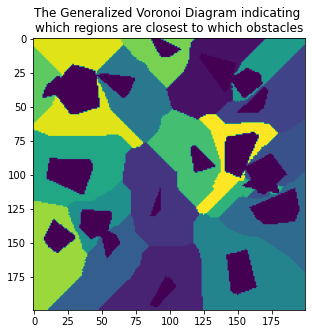

In [6]:
img_done, obs_img_done = brushfire(img, obs_img, all_obs_pts)

plt.figure()
plt.imshow(img_done)
plt.title("The brushfire values indicating distance from \nan obstacle")

plt.figure()
plt.imshow(obs_img_done)
plt.title("The Generalized Voronoi Diagram indicating \nwhich regions are closest to which obstacles")
    

# Identify the boundary points

Our next task is to identify all the points that lie on the boundary of two Voronoi regions. If these points are all connected together into a graph, they form a network that reaches into all connected free space. This network can always be reached by traveling in the direction of increasing brushfire values. This means you can always travel from a region to the roadmap. The roadmap allows you to travel from the edge of any one region to the edge of any other region. Combining these two pieces, we have a map that allows traversing from any point in free space to any connected point in free space without turning the entire area into a graph which would take more time to plan paths through.

To identify which points form the boundary, we simply identify points that are:
* not in an obstacle and
* have at least one neighbor from a different Voronoi region

Because we didn't consider the edges of the map to be obstacles, we also have to add any point on the edge of the map that is in free space. The following section computes the list of boundary points and plots them.

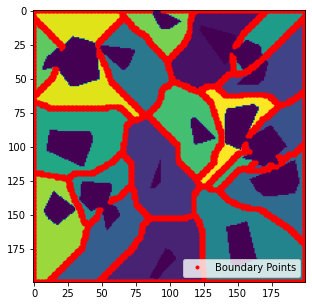

In [7]:
def get_neighbor_vals(img, pt):
    vals = []
    for pair in pairs:
        a = pt[0] + pair[0]
        b = pt[1] + pair[1]
        if a >= 0 and a < img.shape[1] and b >= 0 and b < img.shape[0]:
            vals.append(img[b,a])
    return vals

def is_boundary_pt(img, pt):
    col, row = pt
    neighbor_vals = get_neighbor_vals(img,pt)
    for val in neighbor_vals:
        if img[row,col] >=0:
            if row == 0 or col == 0 or row == img.shape[0]-1 or col == img.shape[1]-1:
                return True
            
            if img[row, col] != val and val >= 0:
                return True
    return False


                        
boundary_pts = []
for row in range(obs_img_done.shape[0]):
    for col in range(obs_img_done.shape[1]):
        if is_boundary_pt(obs_img_done, [col,row]):
            boundary_pts.append([col,row])
boundary_pts = np.array(boundary_pts)
fig, ax = plt.subplots()
ax.imshow(obs_img_done)
ax.plot(boundary_pts[:,0],boundary_pts[:,1],'r.',label='Boundary Points')
plt.legend()
                

# Converting the boundary points into a graph

I reused my Graph class and A* code from the previous assignments to convert the boundary points into a graph. We iterate through every pixel that is a boundary point and add an edge to every neighbor that is also a boundary point. In order to avoid checking the same pair twice, we only consider the three neighbors to the right of the pixel and the one neighbor directly beneath. We then draw the graph on our diagram and see that it covers all the boundaries.

In [8]:
class Node():
    def __init__(self, xy, hfunc):
        self.neighbors = {}
        self.g = np.Inf
        self.xy = np.array(xy)
        self.hfunc = hfunc

    def __lt__(self, other):
        lt = False
        f1 = self.g+self.hfunc(self.xy)
        f2 = other.g+self.hfunc(self.xy)
        if np.abs(f1-f2) < 0.001:
            #print("almost equal")
            lt = self.g > other.g
        else:
            lt = f1 < f2
            
        #lt = f1 < f2
        return lt

    def __eq__(self, other):
        return all(self.xy == other.xy)
    
    def __call__(self):
        return self.hfunc(np.array([self.x, self.y]))
        try:
            return self.f
        except:
            self.f = self.g+self.hfunc(np.array([self.x, self.y]))
            return self.f


class Graph():
    def __init__(self, dist_func):
        self.nodes = {}
        self.dist_func = dist_func
        
    def __iadd__(self, t):
        n1 = t[0]
        n2 = t[1]
        weight = t[2]
        self.connect(n1, n2, weight)
        return self
        
    def connect(self, n1, n2, weight):
        try:
            self.nodes[n1].neighbors[n2] = weight
        except KeyError:
            self.nodes[n1] = Node(n1, self.hfunc)
            self.nodes[n1].neighbors[n2] = weight
        try:
            self.nodes[n2].neighbors[n1] = weight
        except KeyError:
            self.nodes[n2] = Node(n2,self.hfunc)
            self.nodes[n2].neighbors[n1] = weight

    def draw(self, ax):
        for pt in self.nodes:
            node = self.nodes[pt]
            for neighbor in node.neighbors:
                ax.plot([pt[0],neighbor[0]],[pt[1], neighbor[1]],'k')
                
    def hfunc(self, node):
        return self.dist_func(node, self.goal)
        

def h_l2_dist(node, goal):
    return np.linalg.norm(node-goal)

import heapq
import copy

def a_star(graph, start, goal, max_iter = np.Inf):
    graph = copy.deepcopy(graph)
    start_node = graph.nodes[start[0], start[1]]
    start_node.g = 0

    goal_node = graph.nodes[goal[0], goal[1]]
    graph.goal = goal

    start_node.goal = goal
    Q = [start_node]
    heapq.heapify(Q)
    searched = []
    curr_node = start_node
    count = 0
    while len(Q) > 0 and curr_node != goal_node and count < max_iter:
        curr_node = heapq.heappop(Q)
        count += 1

        searched.append(curr_node.xy)
        for neighbor in curr_node.neighbors:
            weight = curr_node.neighbors[neighbor]
            try:
                other_node = graph.nodes[neighbor]
                if curr_node.g + weight < other_node.g:
                    other_node.g = curr_node.g + weight
                    other_node.prev = curr_node
                    if other_node not in Q:
                        other_node.goal = goal
                        heapq.heappush(Q, other_node)
            except:
                pass
    if len(Q) == 0:
        print("No solution found")
        return graph, np.array([[start_node.x, start_node.y]]), np.array(searched), 0
    path = [curr_node.xy]
    path_cum_length = [0]
    path_length = 0
    while curr_node != start_node:
        path.insert(0, curr_node.prev.xy)
        path_length += np.linalg.norm(curr_node.xy-curr_node.prev.xy)
        path_cum_length.append(path_length)
        curr_node = curr_node.prev

    return graph, np.array(path), np.array(searched), np.array(path_cum_length)

Text(0.5, 1.0, 'The graph of connected points on the \nVoronoi Boundaries')

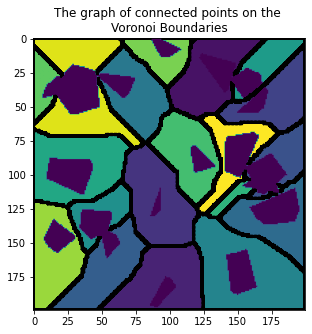

In [13]:
right_down_pairs = [[1,-1],[1,0],[1,1],[0,1]]

def get_right_down_neighbors(img, pt):
    col, row = pt
    neighbors = []
    for pair in right_down_pairs:
        a = col + pair[0]
        b = row + pair[1]
        if a >= 0 and a < img.shape[1] and b >= 0 and b < img.shape[0]:
            neighbors.append((a,b))
    return neighbors
    
def is_on_edge(img,pt):
    col,row = pt
    if row == 0 or col == 0 or row == img.shape[0]-1 or col == img.shape[1]-1:
        return True
    else:
        return False
    
def create_graph(img):
    graph = Graph(h_l2_dist)
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            val = img[row,col]
            if not is_boundary_pt(img, (col,row)):
                continue
            
            for neighbor in get_right_down_neighbors(img, (col,row)):
                if is_boundary_pt(img, neighbor):
                    graph += ((col,row), neighbor, np.linalg.norm(np.array((col,row))-np.array(neighbor)))
    return graph

graph = create_graph(obs_img_done)

fig, ax = plt.subplots()
ax.imshow(obs_img_done)
graph.draw(ax)
plt.title("The graph of connected points on the \nVoronoi Boundaries")



# Find a path between arbitrary points

Now that we have a graph representing the roadmap, we can find a path between two connected nodes in the domain. To do this, we first compute a path from the start point to the graph by iteratively stepping to a neighbor with a larger brushfire value until we reach a node that is a member of the graph. We duplicate this process for the goal point, stepping from the goal until we reach a node on the graph (in this case we prepend instead of append so that the resulting path goes from the graph to the goal instead of from the goal to the graph). Finally we use A* to compute a path from the final point in the start path to the first point in the goal path. Provided that the two nodes aren't completely isolated from each other by obstacles, this will always return a solution. We can then stitch the three segments together and return the complete path which we plot. The section below demonstrates solutions for 10 random sets of start and goal points.

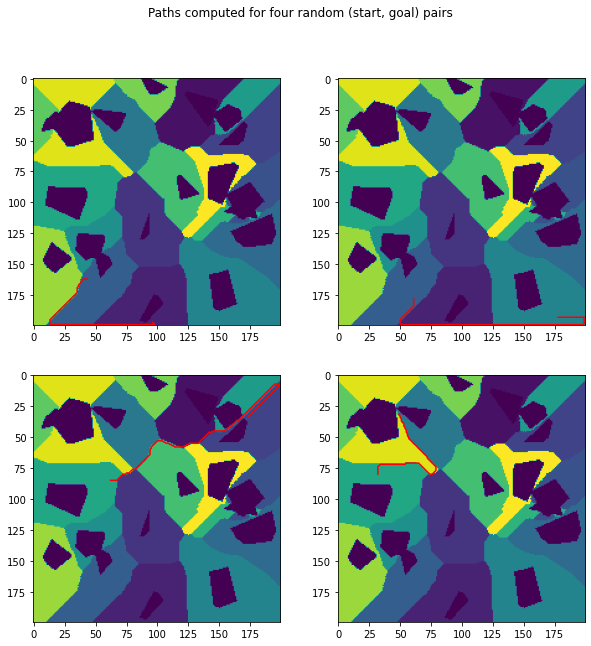

In [10]:

def get_neighbors(img, pt):
    col, row = pt
    neighbors = []
    for pair in pairs:
        a = col + pair[0]
        b = row + pair[1]
        if a >= 0 and a < img.shape[1] and b >= 0 and b < img.shape[0]:
            neighbors.append((a,b))
    return neighbors

def find_path(img, graph, start_pt, goal_pt):
    curr_pt = tuple(start_pt)
    start_path = []
    count = 0
    start_path.append(curr_pt)
    skip_graph = False

    while not curr_pt in graph.nodes and count < 1000:
        count +=1
#         print(curr_pt, img[curr_pt[1],curr_pt[0]])
        min_dist = 2
        for nx,ny in get_neighbors(img, curr_pt):
#             print((nx,ny), img[ny,nx])
            dist = np.sqrt((nx-curr_pt[0])**2+(ny-curr_pt[1])**2)
            if img[ny,nx] > img[curr_pt[1], curr_pt[0]] and dist < min_dist:
                min_pt = (nx,ny)
                min_dist = dist
        curr_pt = min_pt
        start_path.append(curr_pt)
    if count >= 1000:
        skip_graph = True
        print("problem")

    
    curr_pt = tuple(goal_pt)
    goal_path = []
    count = 0
    goal_path.insert(0, curr_pt)
    while not curr_pt in graph.nodes and count < 1000:
        goal_path.insert(0, curr_pt)
        count +=1
#         print(curr_pt, img[curr_pt[1],curr_pt[0]])
        min_dist = 2
        for nx,ny in get_neighbors(img, curr_pt):
#             print((nx,ny), img[ny,nx])
            dist = np.sqrt((nx-curr_pt[0])**2+(ny-curr_pt[1])**2)
            if img[ny,nx] > img[curr_pt[1], curr_pt[0]] and dist < min_dist:
                min_pt = (nx,ny)
                min_dist = dist
        curr_pt = min_pt
        goal_path.insert(0, curr_pt)
    if count >= 1000:
        skip_graph = True
        print("problem")
    if not skip_graph:
        new_graph, roadmap_path, searched, path_cum_length = a_star(graph, start_path[-1], goal_path[0])
        return np.concatenate([start_path ,roadmap_path , goal_path])
    else:
        return np.concatenate([start_path , goal_path])

plt.rcParams['figure.figsize'] = [10,10]

fig, axes = plt.subplots(2,2)
fig.suptitle("Paths computed for four random (start, goal) pairs")

for i in range(4):
    while True:
        start_pt = np.random.randint(0,img_done.shape[0],2)
        if img_done[start_pt[1], start_pt[0]] > 0:
            break
#     print(start_pt)
    while True:
        goal_pt = np.random.randint(0,img_done.shape[0], 2)
        if img_done[goal_pt[1], goal_pt[0]] > 0:
            break
#     print(goal_pt)
        
    path = find_path(img_done, graph, start_pt, goal_pt)
#     fig, ax = plt.subplots()
    ax = axes[i//2,i%2]
    ax.imshow(obs_img_done)
    ax.plot(path[:,0],path[:,1],'r')
    
plt.rcParams['figure.figsize'] = [5,5]


                

# Conclusion

A generalized Voronoi diagram can be used to create a roadmap of a space. Once this has been created, it allows quick path planning from a starting to an ending point along a path that maximizes the distance from obstacles. It is by no means the shortest path, but it is nonetheless an effective tool.